In [2]:
import csv
import timeit
import numba
from numba import cuda, jit
import numpy as np


In [3]:
@cuda.jit
def cuda_matmul(matrix_a, matrix_b, matrix_c):
    """
    Ядро CUDA для матричного умножения.

    Args:
        matrix_a: Первая матрица.
        matrix_b: Вторая матрица.
        matrix_c: Результирующая матрица.
    """
    row, col = cuda.grid(2)
    if row < matrix_c.shape[0] and col < matrix_c.shape[1]:
        sum_val = 0
        for k in range(matrix_a.shape[1]):
            sum_val += matrix_a[row, k] * matrix_b[k, col]
        matrix_c[row, col] = sum_val

@jit(nopython=True, cache=True)
def cpu_jit_matmul(matrix_a, matrix_b):
    """
    Умножение матриц с использованием JIT-компиляции.

    Args:
        matrix_a: Первая матрица.
        matrix_b: Вторая матрица.

    Returns:
        Матрица-произведение.
    """
    matrix_c = np.zeros((matrix_a.shape[0], matrix_b.shape[1]))
    for i in range(matrix_a.shape[0]):
        for j in range(matrix_b.shape[1]):
            for k in range(matrix_a.shape[1]):
                matrix_c[i, j] += matrix_a[i, k] * matrix_b[k, j]
    return matrix_c

def cpu_matmul(matrix_a, matrix_b):
    """
    Обычное матричное умножение.

    Args:
        matrix_a: Первая матрица.
        matrix_b: Вторая матрица.

    Returns:
        Матрица-произведение.
    """
    return np.dot(matrix_a, matrix_b)

def run_cuda_matmul(matrix_a, matrix_b):
    """
    Умножение матриц на GPU.

    Args:
        matrix_a: Первая матрица.
        matrix_b: Вторая матрица.

    Returns:
        Матрица-произведение.
    """
    d_A = cuda.to_device(matrix_a)
    d_B = cuda.to_device(matrix_b)
    d_C = cuda.device_array((matrix_a.shape[0], matrix_b.shape[1]))

    threads_per_block = (16, 16)
    blocks_per_grid_x = (matrix_a.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (matrix_b.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]

    cuda_matmul[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](d_A, d_B, d_C)
    return d_C.copy_to_host()


In [4]:
matrix_sizes = [100, 250, 500, 750, 1000]
number_of_tests = 12
results = []

for size in matrix_sizes:
    A = np.random.randint(1, 10, (size, size))
    B = np.random.randint(1, 10, (size, size))

    cpu_time = timeit.timeit(lambda: cpu_matmul(A, B), number=1)
    cpu_jit_time = timeit.timeit(lambda: cpu_jit_matmul(A, B), number=number_of_tests) / number_of_tests
    cuda_time = timeit.timeit(lambda: run_cuda_matmul(A, B), number=number_of_tests) / number_of_tests
    numpy_time = timeit.timeit(lambda: np.dot(A, B), number=number_of_tests) / number_of_tests

    results.append([size, cpu_time, cpu_jit_time, cuda_time, numpy_time,
                    cpu_time / cpu_jit_time, cpu_time / cuda_time, cpu_time / numpy_time])

    print(f"Matrix size: {size}")
    print(f"CPU time: {cpu_time:.6f}s")
    print(f"CPU JIT time: {cpu_jit_time:.6f}s")
    print(f"CUDA time: {cuda_time:.6f}s")
    print(f"Numpy dot time: {numpy_time:.6f}s")

# Запись результатов в CSV
with open('results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Matrix size", "CPU time (s)", "CPU JIT time (s)", "CUDA time (s)", "Numpy dot time (s)",
                     "CPU JIT speedup", "CUDA speedup", "Numpy dot speedup"])
    writer.writerows(results)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Matrix size: 100
CPU time: 0.000837s
CPU JIT time: 0.134605s
CUDA time: 0.087443s
Numpy dot time: 0.000812s
Matrix size: 250
CPU time: 0.014592s
CPU JIT time: 0.020498s
CUDA time: 0.002195s
Numpy dot time: 0.013597s
Matrix size: 500
CPU time: 0.153211s
CPU JIT time: 0.203331s
CUDA time: 0.009676s
Numpy dot time: 0.146262s
Matrix size: 750
CPU time: 0.477702s
CPU JIT time: 0.661999s
CUDA time: 0.023446s
Numpy dot time: 0.480224s
Matrix size: 1000
CPU time: 1.069833s
CPU JIT time: 1.552784s
CUDA time: 0.044423s
Numpy dot time: 1.149098s


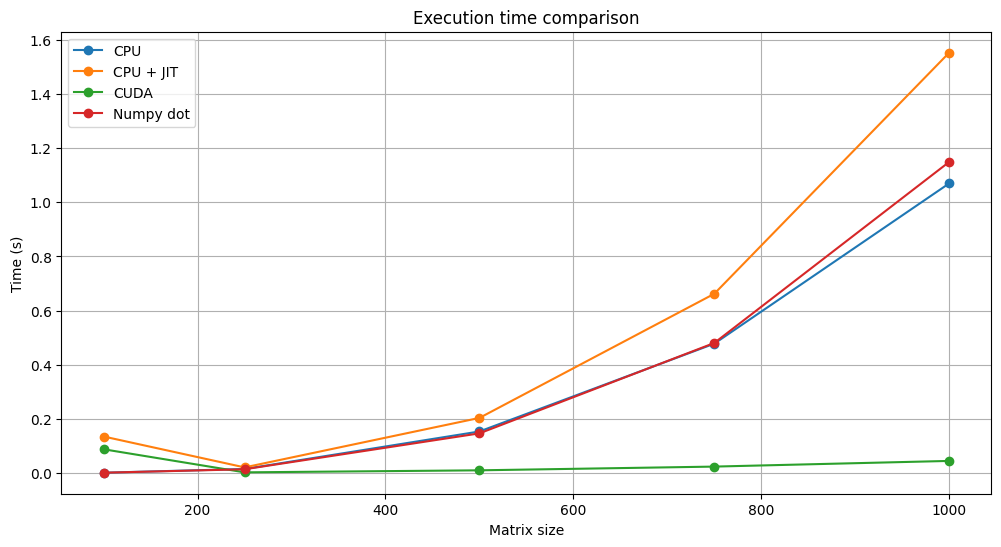

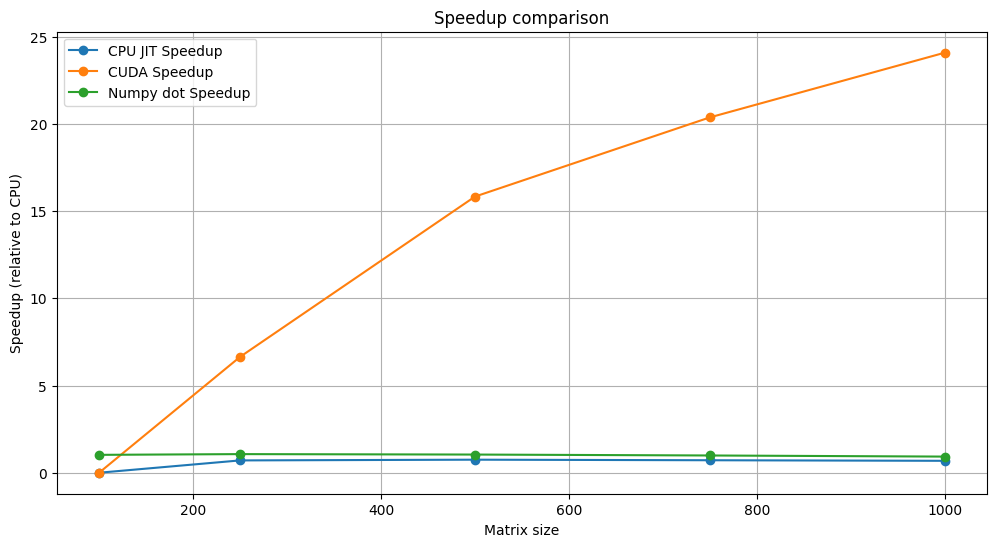

In [6]:
import matplotlib.pyplot as plt

# Построение графиков времени выполнения
matrix_sizes = [result[0] for result in results]
cpu_times = [result[1] for result in results]
cpu_jit_times = [result[2] for result in results]
cuda_times = [result[3] for result in results]
numpy_times = [result[4] for result in results]

plt.figure(figsize=(12, 6))
plt.plot(matrix_sizes, cpu_times, label='CPU', marker='o')
plt.plot(matrix_sizes, cpu_jit_times, label='CPU + JIT', marker='o')
plt.plot(matrix_sizes, cuda_times, label='CUDA', marker='o')
plt.plot(matrix_sizes, numpy_times, label='Numpy dot', marker='o')
plt.xlabel('Matrix size')
plt.ylabel('Time (s)')
plt.title('Execution time comparison')
plt.legend()
plt.grid(True)
plt.savefig('execution_times.png')  # Сохраняем график
plt.show()

# Построение графиков ускорения
cpu_jit_speedup = [result[5] for result in results]
cuda_speedup = [result[6] for result in results]
numpy_speedup = [result[7] for result in results]

plt.figure(figsize=(12, 6))
plt.plot(matrix_sizes, cpu_jit_speedup, label='CPU JIT Speedup', marker='o')
plt.plot(matrix_sizes, cuda_speedup, label='CUDA Speedup', marker='o')
plt.plot(matrix_sizes, numpy_speedup, label='Numpy dot Speedup', marker='o')
plt.xlabel('Matrix size')
plt.ylabel('Speedup (relative to CPU)')
plt.title('Speedup comparison')
plt.legend()
plt.grid(True)
plt.savefig('speedup_comparison.png')  # Сохраняем график
plt.show()
